# pair trading

In [1]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os

In [8]:
def check_cointegration(tic1, tic2):
    api_key = os.getenv('ALPHA_VANTAGE_API_KEY')  # replace this with your actual key
    ts = TimeSeries(key=api_key, output_format='pandas')
    
    # 3. Download full daily adjusted close prices for IVV and DIA
    IVV_data, _ = ts.get_daily_adjusted(symbol=tic1, outputsize='full')
    dia_data, _ = ts.get_daily_adjusted(symbol=tic2, outputsize='full')
    
    # 4. Extract adjusted close and align on dates
    IVV = IVV_data['5. adjusted close']
    dia = dia_data['5. adjusted close']
    data = pd.concat([IVV, dia], axis=1, join='inner')
    data.columns = [tic1, tic2]
    data = data.sort_index()
    
    # 5. Linear regression to get hedge ratio
    X = sm.add_constant(data[tic2])
    model = sm.OLS(data[tic1], X).fit()
    hedge_ratio = model.params[tic2]
    
    # 6. Compute spread
    spread = data[tic1] - hedge_ratio * data[tic2]
    
    # 7. Plot spread
    plt.figure(figsize=(12, 6))
    plt.plot(spread, label='Spread')
    plt.axhline(spread.mean(), color='r', linestyle='--', label='Mean')
    plt.title(f"Spread Between {tic1} and {tic2} (Alpha Vantage)")
    plt.xlabel("Date")
    plt.ylabel("Spread")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 8. Perform Augmented Dickey-Fuller test
    adf_result = sm.tsa.adfuller(spread)
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"P-value: {adf_result[1]}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"  {key}: {value}")


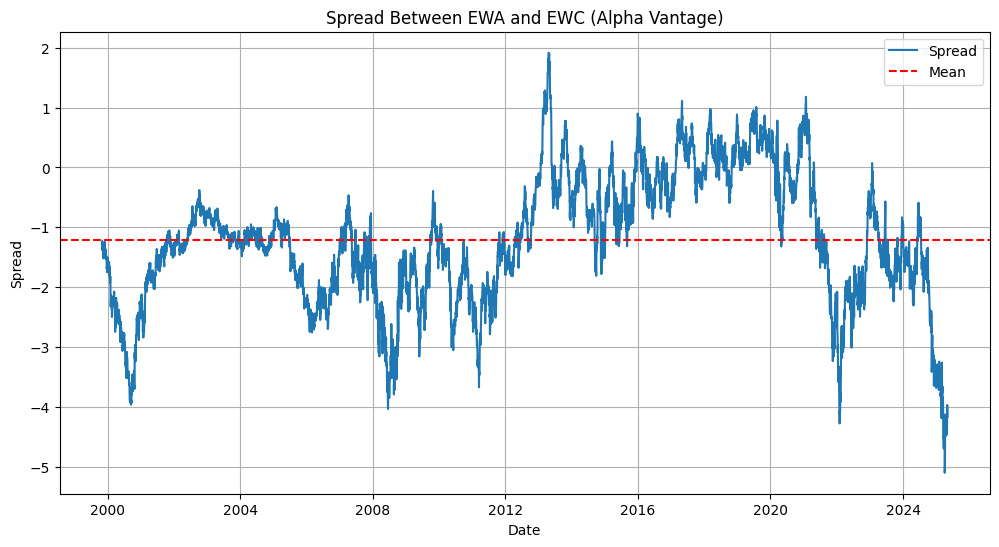

ADF Statistic: -2.983605366325247
P-value: 0.03645407793912503
Critical Values:
  1%: -3.4313723355465333
  5%: -2.8619917835042554
  10%: -2.567010481165001


In [9]:
check_cointegration('EWA', 'EWC')